In [1]:
import numpy as np
import matplotlib.pyplot as plt

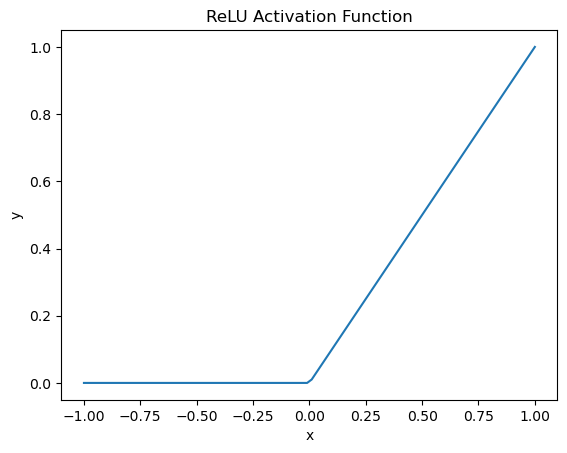

In [10]:
x = np.linspace(-1, 1, 100)
y = np.maximum(0, x)
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("ReLU Activation Function")
plt.savefig("Figure_7.png")

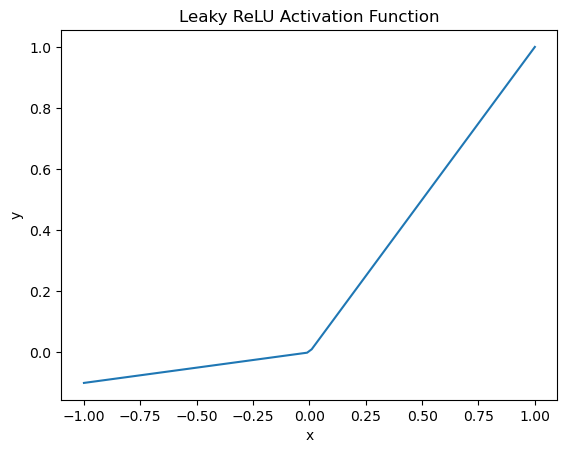

In [11]:
x = np.linspace(-1, 1, 100)
y = np.maximum(0.1*x, x)

plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Leaky ReLU Activation Function")
plt.savefig("Figure_8.png")

In [20]:
from torchvision.datasets import MNIST

In [24]:
# init with the 'data' dir
mnist_trainset = MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = MNIST(root='./data', train=False, download=True, transform=None)

100%|██████████| 9912422/9912422 [00:00<00:00, 16129739.96it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 45386172.28it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 3122607.34it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14195625.01it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



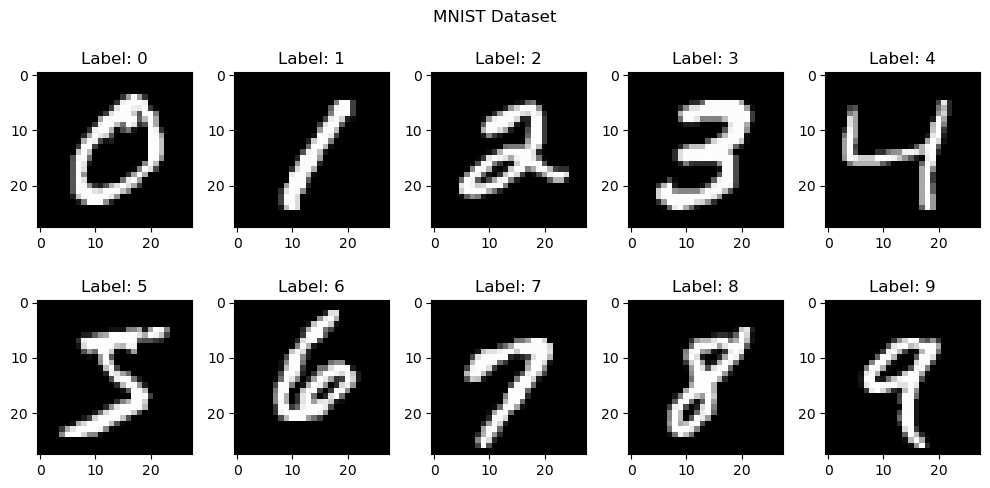

In [65]:
xs = [None]*10
idxs = np.arange(10)
for i, (x, y) in enumerate(mnist_trainset):
    x = np.array(x)

    if np.isin(y, idxs):
        xs[y] = x
        idxs = np.delete(idxs, np.where(idxs == y))

    if len(idxs) == 0:
        break
xs = np.array(xs)

fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(xs[i], cmap='gray')
    ax.set_title(f"Label: {i}")

plt.suptitle("MNIST Dataset")
plt.tight_layout()
plt.savefig("Figure_9.png")

In [92]:
train_x = mnist_trainset.data.numpy()
train_y = mnist_trainset.targets.numpy()
test_x = mnist_testset.data.numpy()
test_y = mnist_testset.targets.numpy()

In [101]:
print(train_x.min(), train_x.max(), train_x.mean())
print(train_y.min(), train_y.max(), train_y.mean())
print(test_x.min(), test_x.max(), test_x.mean())
print(test_y.min(), test_y.max(), test_y.mean())

0 255 33.318421449829934
0 9 4.4539333333333335
0 255 33.791224489795916
0 9 4.4434


In [93]:
print(train_x.shape, train_x.dtype)
print(train_y.shape, train_y.dtype)
print(test_x.shape, test_x.dtype)
print(test_y.shape, test_y.dtype)

(60000, 28, 28) uint8
(60000,) int64
(10000, 28, 28) uint8
(10000,) int64


In [81]:
train_idxs = np.argsort(train_y)
train_x = train_x[train_idxs]
train_y = train_y[train_idxs]

idxs = np.argsort(test_y)
test_x = test_x[idxs]
test_y = test_y[idxs]

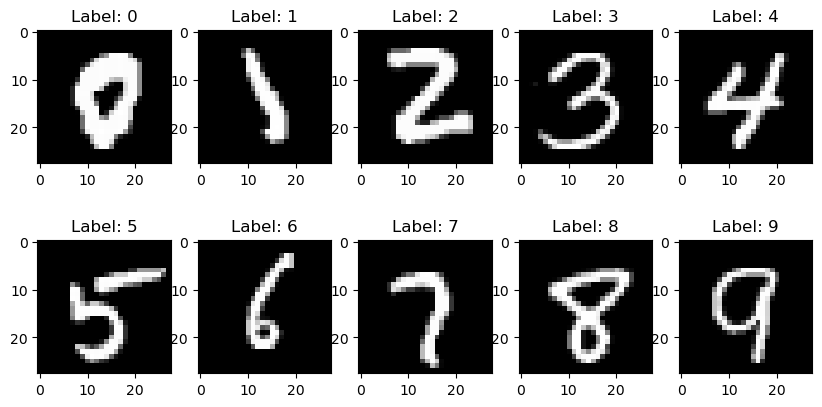

In [123]:
# Plot samples by picking random indices from each class
from IPython.display import clear_output
import time

fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for j in range(20):
    clear_output(wait=True)
    for i, ax in enumerate(axs.flatten()):
        class_idxs = np.where(train_y == i)[0]
        idx = np.random.choice(class_idxs)
        ax.imshow(train_x[idx], cmap='gray')
        ax.set_title(f"Label: {train_y[idx]}")
    plt.show()
    time.sleep(1)
    clear_output(wait=True)
    plt.show()


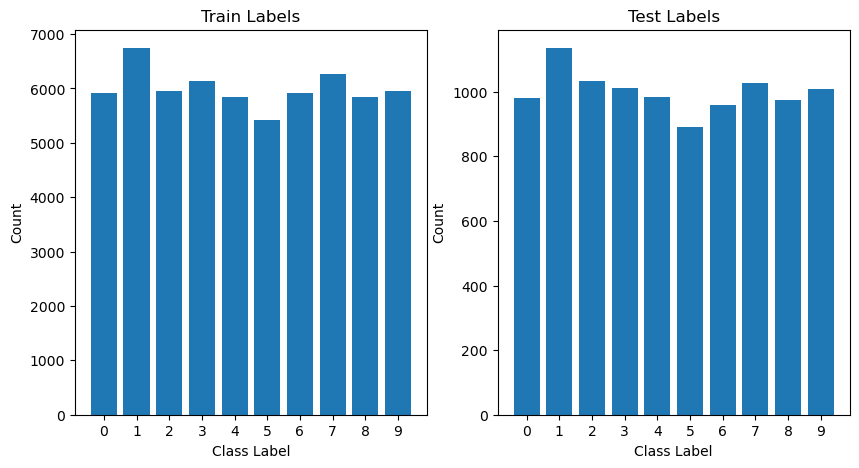

In [112]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
train_counts = np.unique(train_y, return_counts=True)
axs[0].bar(train_counts[0], train_counts[1])
axs[0].set_xticks(np.arange(10))
axs[0].set_xlabel("Class Label")
axs[0].set_ylabel("Count")
axs[0].set_title("Train Labels")

test_counts = np.unique(test_y, return_counts=True)
axs[1].bar(test_counts[0], test_counts[1])
axs[1].set_xticks(np.arange(10))
axs[1].set_xlabel("Class Label")
axs[1].set_ylabel("Count")
axs[1].set_title("Test Labels")

plt.savefig("Figure_10.png")

In [96]:
class DNN():
    def __init__(self, layers=4, hidden_dim=128, lr=0.001):
        self.layers = layers
        self.hidden_dim = hidden_dim
        self.lr = lr

        self.params = {}
        self.grads = {}
        self.cache = {}
        
        self._init_params()

    def _init_params(self):
        self.params['W1'] = np.random.randn(784, self.hidden_dim) * 0.01
        self.params['b1'] = np.zeros(self.hidden_dim)
        for i in range(2, self.layers):
            self.params[f'W{i}'] = np.random.randn(self.hidden_dim, self.hidden_dim) * 0.01
            self.params[f'b{i}'] = np.zeros(self.hidden_dim)
        self.params[f'W{self.layers}'] = np.random.randn(self.hidden_dim, 10) * 0.01
        self.params[f'b{self.layers}'] = np.zeros(10)

    def _relu(self, x):
        return np.maximum(0, x)

    def _softmax(self, x):
        exp = np.exp(x)
        return exp / np.sum(exp, axis=1, keepdims=True)

    def _cross_entropy(self, y, y_hat):
        return -np.sum(y * np.log(y_hat + 1e-7)) / y.shape[0]

    def _forward(self, x):
        self.cache['A0'] = x
        for i in range(1, self.layers):
            self.cache[f'Z{i}'] = np.dot(self.cache[f'A{i-1}'], self.params[f'W{i}']) + self.params[f'b{i}']
            self.cache[f'A{i}'] = self._relu(self.cache[f'Z{i}'])
        self.cache[f'Z{self.layers}'] = np.dot(self.cache[f'A{self.layers-1}'], self.params[f'W{self.layers}']) + self.params[f'b{self.layers}']
        self.cache[f'A{self.layers}'] = self._softmax(self.cache[f'Z{self.layers}'])
    
        return self.cache[f'A{self.layers}']

    def _backward(self, y):
        self.grads[f'dZ{self.layers}'] = self.cache[f'A{self.layers}'] - y
        self.grads[f'dW{self.layers}'] = np.dot(self.cache[f'A{self.layers-1}'].T, self.grads[f'dZ{self.layers}'])
        self.grads[f'db{self.layers}'] = np.sum(self.grads[f'dZ{self.layers}'], axis=0)
        for i in range(self.layers-1, 0, -1):
            self.grads[f'dA{i}'] = np.dot(self.grads[f'dZ{i+1}'], self.params[f'W{i+1}'].T)
            self.grads[f'dZ{i}'] = self.grads[f'dA{i}'] * (self.cache[f'Z{i}'] > 0).astype(np.float32)
            self.grads[f'dW{i}'] = np.dot(self.cache[f'A{i-1}'].T, self.grads[f'dZ{i}'])
            self.grads[f'db{i}'] = np.sum(self.grads[f'dZ{i}'], axis=0)

    def _update(self):
        for i in range(1, self.layers+1):
            self.params[f'W{i}'] -= self.lr * self.grads[f'dW{i}']
            self.params[f'b{i}'] -= self.lr * self.grads[f'db{i}']

    def train(self, x, y):
        y_hat = self._forward(x)
        loss = self._cross_entropy(y, y_hat)
        self._backward(y)
        self._update()

        return loss

    def predict(self, x):
        return np.argmax(self._forward(x), axis=1)

    def evaluate(self, x, y):
        y_hat = self._forward(x)
        loss = self._cross_entropy(y, y_hat)
        accuracy = np.mean(np.argmax(y_hat, axis=1) == np.argmax(y, axis=1))

        return loss, accuracy

dnn = DNN(layers=4, hidden_dim=128, lr=0.001)

In [ ]:
batch_size = 16


for epoch in range(epochs=100):

    for i in range(0, train_x.shape[0], batch_size):
        
        
        loss = train(self, x, y)
        print(f"Epoch: {epoch+1} | Loss: {loss:.5f}")